<img src="https://user-images.githubusercontent.com/23629340/40541063-a07a0a8a-601a-11e8-91b5-2f13e4e6b441.png" alt="logo_ironhack_blue 7" width="100" height="100">

# Ironhack Mid-Bootcamp Project

## Project Overview

Electric Vehicles (EVs) have been around for a couple decades, but its adoption has really picked up in the last 3 years. In this project we will analyze the increasing demand of EVs and who's leading it, figure out in which stage of adoption we are (according to Everett M. Rogger's [*Diffusion of Innovation Theory*](https://en.wikipedia.org/wiki/Diffusion_of_innovations)) and try to estimate how long will it take for the all car transportation to become electric by finding the EV adoption curve.

According to Rogers, when analyzing the adoption of an innovation, the population penetration follows a **normal distribution** and therefore the market share curve will follow its **cumulative distribution function**.
<div align="center">
<img src="http://steveboese.squarespace.com/storage/adoption_of_tech_no_title.jpg?__SQUARESPACE_CACHEVERSION=1450230149150" alt="Adoption curve examples" width="500">
<img src="https://i0.wp.com/ondigitalmarketing.com/wp-content/uploads/2012/01/640px-Diffusionofideas.png?ssl=1" alt="Adoption curve" width="500">
</div>



## Objective
The objective if this project is to answer the following questions:
1. What is the current stage of Electric Vehicle (EV) adoption? Are we in the phase of Innovators, Early adopters, Early majority, Late majority, or Laggards?
2. Which countries are leading the adoption of EVs? And lagging in the adoption?
3. Which countries are adopting EV's faster (rate of adoption)?
4. What trend (linear, cuadratic, exponential...) is EV adoption currently following?
5. How long will full EV adoption take?

Extra:
1. Which companies are leading the transition from ICE (Internal Combustion Engine) vehicles to EVs?
2. Compare the adoption of electric cars to other vehicles (trucks, vans and buses)

### Finding the EV adoption curve:
+ Assuming our datapoints follow a normal distribution, our sales share data points correspond to x values in the Cumulative Distribution Function:
    + $CDF = \Phi(x) = 0.5 * [1 + \frac{erf((x - \mu)}{(\sigma * \sqrt{2}))}]$ where μ is the mean, σ is the standard deviation, and erf() is the error function. We want to find μ and σ so that this equation holds for all of our points. This leads to a system of n nonlinear equations.
    + Using scipy's least squares solver we will atempt to solve for μ & σ.
        + Other options: multiplicadores de Lagrange, https://docs.scipy.org/doc/scipy/reference/optimize.html
    + Three different scenarios will be estimated: (1) pessimistic, (2) moderate, and (3) optimistic

## Datasets

+ 2010-2022 Global data on EV sales -> [Global EV Data Explorer](https://www.iea.org/data-and-statistics/data-tools/global-ev-data-explorer)
+ 2010-2022 Global data on car sales -> [Global Passenger Car Sales](https://www.iea.org/data-and-statistics/charts/passenger-car-sales-2010-2022)
+ Historical data on company sales and sales share:
    + [Best Selling Cars](https://www.best-selling-cars.com/brands/2021-full-year-global-volkswagen-brand-worldwide-car-sales-by-model-and-country/)
    + [Toyota](https://global.toyota/en/newsroom/corporate/20966057.html)
    + [EV Adoption](https://evadoption.com/ev-sales/evs-percent-of-vehicle-sales-by-brand/)

# 1 Load libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit

# 2 Data Cleaning

## 2.1 Load & Save Raw Data

In [2]:
# Global car sales extracted manually from Internation Energy Agency (IEA) website
car_sales = {'year':[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
             'value': [66700000,71200000,73800000,77500000,80000000,81800000,86400000,86300000,85600000,81300000,71800000,74900000,74800000]}

# Convert dictionary into Pandas Dataframe
car_sales_df = pd.DataFrame(car_sales)

# Save raw data as .csv
car_sales_df.to_csv('../data/raw_data/car_sales_raw.csv',index = False, sep=",")

# Show data
car_sales_df

,year,value
0,2010,66700000
1,2011,71200000
2,2012,73800000
3,2013,77500000
4,2014,80000000
5,2015,81800000
6,2016,86400000
7,2017,86300000
8,2018,85600000
9,2019,81300000


In [3]:
# IEA Global EV Data Explorer API url
api_url = 'https://api.iea.org/evs/?parameter=EV%20sales&mode=Cars&category=Historical&csv=true'

# Download data from IEA website
ev_sales_df = pd.read_csv(api_url)

# Save raw data as .csv
ev_sales_df.to_csv('../data/raw_data/ev_sales_raw.csv',index = False, sep=",")

# Initial dataset overview
display(ev_sales_df.head())
display(ev_sales_df.shape)

,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV sales,Cars,BEV,2011,Vehicles,49
1,Australia,Historical,EV sales,Cars,BEV,2012,Vehicles,170
2,Australia,Historical,EV sales,Cars,PHEV,2012,Vehicles,80
3,Australia,Historical,EV sales,Cars,PHEV,2013,Vehicles,100
4,Australia,Historical,EV sales,Cars,BEV,2013,Vehicles,190


(834, 8)

## 2.2 Explore Data
In this initial data exploration we will explore the ev_sales dataset:
+ study which columns will be useful
+ check for any missing data points
  
car_sales has been extracted manually. There is one value for each year and no missing year values.

In [4]:
# Show values por each column of ev_sales_df
for column in ev_sales_df.columns:
    display(ev_sales_df[column].value_counts())

region
World                26
Belgium              26
United Kingdom       26
China                26
EU27                 26
Europe               26
Germany              25
USA                  25
Spain                25
Poland               25
New Zealand          25
Netherlands          25
Japan                25
France               25
Norway               24
Canada               24
Switzerland          24
Sweden               24
Denmark              24
Other Europe         23
Rest of the world    23
Portugal             23
Australia            23
Finland              23
Italy                23
Israel               23
Iceland              22
Korea                21
Chile                21
Brazil               21
Mexico               20
Turkiye              20
South Africa         19
Austria              18
Greece               18
India                17
Name: count, dtype: int64

category
Historical    834
Name: count, dtype: int64

parameter
EV sales    834
Name: count, dtype: int64

mode
Cars    834
Name: count, dtype: int64

powertrain
BEV     443
PHEV    391
Name: count, dtype: int64

year
2019    72
2020    72
2021    72
2022    72
2015    71
2016    71
2017    71
2018    71
2014    66
2013    63
2012    59
2011    46
2010    28
Name: count, dtype: int64

unit
Vehicles    834
Name: count, dtype: int64

value
1200       12
16000      11
15000      11
11000      10
1500       10
           ..
88000       1
870000      1
510000      1
540000      1
2900000     1
Name: count, Length: 328, dtype: int64

+ In the initial data overview we have found that:
    + 'powertrain' divides ev_sales into PHEV (Plug-in Hybrid Vehicles) and BEV (Battery Electric Vehicles). Since we are only interested in BEV, we will **filter PHEV rows out** and **drop 'powertrain'** column
    + **'category', 'parameter', 'mode', and 'unit'** columns only have 1 possible value. Therefore those columns will be **dropped**.

    + 'region' and 'year' have different number of rows. This indicates we have some missing data. This can be due to:
        + years with 0 sales are excluded (year starts when there are sales), which is in agreement with the 'value' range seen
        + there are missing values for some years


## 2.3 Filter & Clean Data
+ We will **apply the actions in bold stated in the section above** and continue to study the years for each region to decide on next actions.

In [5]:
# Create a dataframe copy to work this section
ev_sales_df1 = ev_sales_df.copy()

# Filter BEV to discard PHEV
ev_sales_df1 = ev_sales_df1[ev_sales_df1['powertrain'] == 'BEV']

# Drop all columns with only 1 value
ev_sales_df1.drop(['category','parameter','mode','powertrain','unit'], axis=1, inplace=True)

# Check top 5 rows
display(ev_sales_df1.head())

,region,year,value
0,Australia,2011,49
1,Australia,2012,170
4,Australia,2013,190
5,Australia,2014,370
8,Australia,2015,760


In the *.value_counts()* above we have seen that there are no 0's in the 'value' column. This suggests that the missing years are the ones where there where no sales. Furthermore, the *.value_counts()* for the years agrees with this statement: earlier years have less values than the most recent ones. However, this doesn't 100% confirm there are no missing rows (years) for all countries. To confirm this, we will have to **check year continuity from the last year (2022) back**.

In [6]:
# Create a function that check for continuity in the years for each region
def check_continuity(df):
    df = df.sort_values(['region', 'year']) # sort values by region and year to ensure chronological order
    missing = []
    for region, group in df.groupby('region'): # iterate df by region groups
        diffs = group['year'].diff() # calculate 
        if not diffs.isin([1, None]).all():  # if there's a difference greater than 1 year
            years = group['year'][diffs > 1]
            for year in years:
                missing.append((region, year - 1))  # previous year is missing
    return missing

In [7]:
# Apply check_continuity function
check_continuity(ev_sales_df1)

[('Turkiye', 2013)]

The only missing value appears to be for region Turkiye, year 2013.

In [8]:
# Check missing value group
ev_sales_df1[ev_sales_df1['region'] == 'Turkiye']

,region,year,value
737,Turkiye,2012,92
740,Turkiye,2014,46
741,Turkiye,2015,120
744,Turkiye,2016,44
745,Turkiye,2017,77
748,Turkiye,2018,190
749,Turkiye,2019,230
752,Turkiye,2020,890
754,Turkiye,2021,3000
755,Turkiye,2022,7000


Sales around year 2013 in Turkiye were really low. In 2012, 92 cars were sold and in 2014, 46 cars were sold. Therefore we conclude the actual sales in Turkiye for the year 2013 were actually 0 - there are no missing values.

In [9]:
# Sort by region and year to ensure chronological order and reset index of dataframe
ev_sales_df1 = ev_sales_df1.sort_values(['region', 'year']).reset_index(drop=True)

## 2.4 Merge Datasets
+ We will now  combine the two datasets: **car_sales_df** and **ev_sales_df1**. To do this we will:
+ **Rename** the column **'value'** in the ev_sales_df to **'ev_sales'**
+ **Add a calculated column** to the ev_sales_df1 called **ev_sales_share**, calculated as: *ev_sales_share = ev_sales / car_sales.value*
+ **Add a new calculated column** to the ev_sales_df1 **'ev_sales_share_change'** to track the share change year by year. *'ev_sales_share_change' = 'ev_sales_share'(current year) - 'ev_sales_share'(previous year)

In [10]:
# Create a copy of the ev_sales_df for this section
ev_sales_df2 = ev_sales_df1.copy()

# Rename the column 'value' to 'ev_sales'
ev_sales_df2.rename( columns = {'value':'ev_sales'}, inplace = True)

# Add calculated column: ev_sales_share = ev_sales / car_sales.value
ev_sales_df2 = ev_sales_df2.join(car_sales_df.set_index('year'), on='year'
                                ).rename(columns={'value':'global_car_sales'}) # Join the global car_sales data
ev_sales_df2['ev_sales_share'] = ((ev_sales_df2['ev_sales'] / ev_sales_df2['global_car_sales']) * 100).round(5)

merged_df = pd.DataFrame()

for country, group in ev_sales_df2.groupby('region'):
    # Add calculated column: 'ev_sales_share_change' = 'ev_sales_share'(current year) - 'ev_sales_share'(previous year)
    group['ev_sales_share_change'] = group['ev_sales_share'] - group['ev_sales_share'].shift(+1)
    group['ev_sales_share_change'].fillna(0, inplace=True)
    # Add calculated column: 'ev_sales_share_growth'
    group['ev_sales_share_growth'] = ((group['ev_sales_share'] - group['ev_sales_share'].shift(+1)) / group['ev_sales_share'].shift(+1)) * 100
    group['ev_sales_share_growth'].fillna(0, inplace=True)
    # Add calculated column: 'ev_sales_growth'
    group['ev_sales_growth'] = ((group['ev_sales'] - group['ev_sales'].shift(+1))/group['ev_sales'].shift(+1)) * 100
    group['ev_sales_growth'].fillna(0, inplace=True)
    # Concatenate the group with the merged dataframe
    merged_df = pd.concat([merged_df, group])

## 2.5 Save Clean Data

In [11]:
# Save clean data as .csv
merged_df.to_csv('../data/clean_data/ev_sales_clean.csv',index = False, sep=",")
df = merged_df.copy() # Create a copy to work with in the rest of the notebook

# 3 Question #1 - Current Stage of EV Adoption

According to Everett M. Roger's *Diffusion of Innovation Theory*, when adopting any innovation, population is divided into the following segments:
<div align="center">
<img src="https://i0.wp.com/ondigitalmarketing.com/wp-content/uploads/2012/01/640px-Diffusionofideas.png?ssl=1" alt="Adoption curve" width=350">
</div>

To find the current stage, we must calculate the acumulated percentage for each segment:
Population segment|Accumulated percentage
------------------|-----------------------
Innovators|0-2.5%
Early Adopters|2.5-16%
Early Majority|16-50%
Late Majority|50-84%
Laggards|84-100%

We will create a function to calculate this dinamically in case we integrate this into a real data system.

In [12]:
def get_population_segment(accum_market_share: float) -> str:
    '''
    '''
    if accum_market_share < 2.5:
        return 'Innovators'
    elif accum_market_share < 16:
        return 'Early Adopters'
    elif accum_market_share < 50:
        return 'Early Majority'
    elif accum_market_share < 84:
        return 'Late Majority'
    elif accum_market_share <= 100:
        return 'Laggards'

Next, we simply have to filter the region to 'World', get the last value, and use the function to return the current stage.

In [13]:
# Filter df to get current_ev_sales_share
current_ev_sales_share = df[df['region'] == 'World']['ev_sales_share'].tail(1).iloc[0]

print('Answer to question #1: We are currently in the {} stage with {}% of car sales being electric.'.format(get_population_segment(current_ev_sales_share),current_ev_sales_share.round(2)))

Answer to question #1: We are currently in the Early Adopters stage with 9.76% of car sales being electric.


# 4 Question #2 - Leading countries in EV sales

In [14]:
# List regions that are not countries to filter them out
exclude_regions = ['World','Europe','EU27','Other Europe','Rest of the world']

# Filter df to get rank of countries
sales_country_rank = df[(df['year']==2022) & (~df['region'].isin(exclude_regions))][['region','ev_sales','ev_sales_share']].sort_values('ev_sales_share', ascending = False)

# Create rank column
sales_country_rank['ev_sales_rank'] = sales_country_rank.reset_index().index + 1

# Get EV global sales for 2022
current_world_sales = df[df['region'] == 'World']['ev_sales'].tail(1).iloc[0]

# Create calculated column with share of ev cars sold over total ev sales by country
sales_country_rank['ev_sales_country_share'] = (sales_country_rank['ev_sales'] / current_world_sales) * 100

# Show top 10 countries
sales_country_rank.head(10)

,region,ev_sales,ev_sales_share,ev_sales_rank,ev_sales_country_share
82,China,4400000,5.88235,1,60.273973
416,USA,800000,1.06952,2,10.958904
158,Germany,470000,0.62834,3,6.438356
429,United Kingdom,270000,0.36096,4,3.698630
145,France,210000,0.28075,5,2.876712
294,Norway,150000,0.20053,6,2.054795
243,Korea,120000,0.16043,7,1.643836
381,Sweden,96000,0.12834,8,1.315068
57,Canada,85000,0.11364,9,1.164384
268,Netherlands,73000,0.09759,10,1.000000


# 5 Question #3 - Leading countries in EV sales growth

In [15]:
ranking_column = 'ev_sales_share_growth'
# years_to_average = 5 To-do?

# Filter df to get rank of countries
sales_growth_country_rank = df[(df['year']==2022) & (~df['region'].isin(exclude_regions))].sort_values(ranking_column, ascending = False)

# Create rank column
sales_growth_country_rank['rank'] = sales_growth_country_rank.reset_index().index + 1

# Show top 10
sales_growth_country_rank.head(10)

,region,year,ev_sales,global_car_sales,ev_sales_share,ev_sales_share_change,ev_sales_share_growth,ev_sales_growth,rank
192,India,2022,48000,74800000,0.06417,0.04815,300.561798,300.000000,1
69,Chile,2022,880,74800000,0.00118,0.00082,227.777778,225.925926,2
45,Brazil,2022,8500,74800000,0.01136,0.00749,193.540052,193.103448,3
281,New Zealand,2022,19000,74800000,0.02540,0.01632,179.735683,179.411765,4
230,Japan,2022,61000,74800000,0.08155,0.05218,177.664283,177.272727,5
204,Israel,2022,27000,74800000,0.03610,0.02141,145.745405,145.454545,6
403,Turkiye,2022,7000,74800000,0.00936,0.00535,133.416459,133.333333,7
355,South Africa,2022,500,74800000,0.00067,0.00038,131.034483,127.272727,8
320,Poland,2022,14000,74800000,0.01872,0.00911,94.797086,94.444444,9
11,Australia,2022,33000,74800000,0.04412,0.02142,94.361233,94.117647,10


# 6 Question #4 - World EV adoption trend

In [43]:
world_df = df[df['region'] == 'World']
x_data = world_df['year']
y_data = world_df['ev_sales_share']
display(x_data.head(30).reset_index(drop=True))
display(y_data.head(30).reset_index(drop=True))

0     2010
1     2011
2     2012
3     2013
4     2014
5     2015
6     2016
7     2017
8     2018
9     2019
10    2020
11    2021
12    2022
Name: year, dtype: int64

0     0.01079
1     0.05478
2     0.07859
3     0.14194
4     0.25000
5     0.40342
6     0.53241
7     0.88065
8     1.63551
9     1.84502
10    2.78552
11    6.14152
12    9.75936
Name: ev_sales_share, dtype: float64

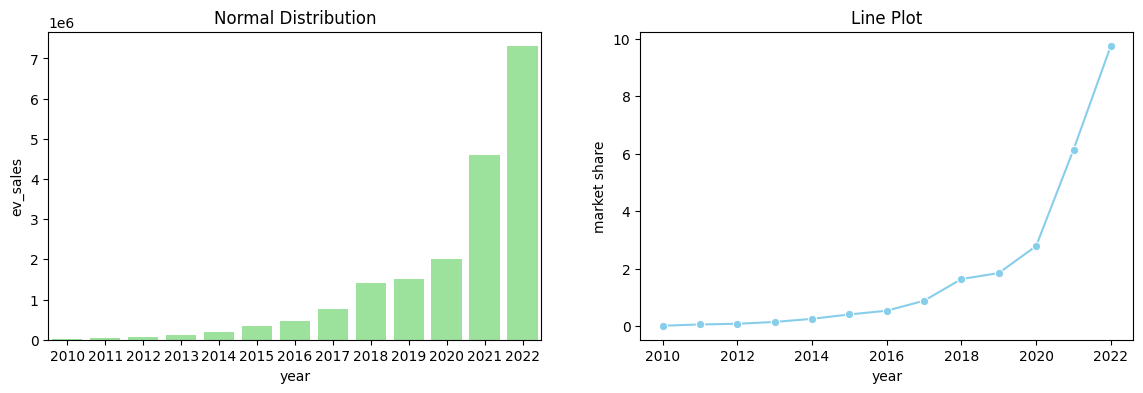

In [44]:
# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Plot the line plot with seaborn
sns.lineplot(data=world_df, x='year', y='ev_sales_share', marker='o', color='skyblue', ax=axes[1])

sns.barplot(data=world_df, x='year', y='ev_sales', color='lightgreen', ax=axes[0])

axes[0].set_title('Normal Distribution')

# Set plot title and labels
axes[1].set_title('Line Plot')
axes[1].set_xlabel('year')
axes[1].set_ylabel('market share')

# Show the plot
plt.show()

Best Fit:  Exponential


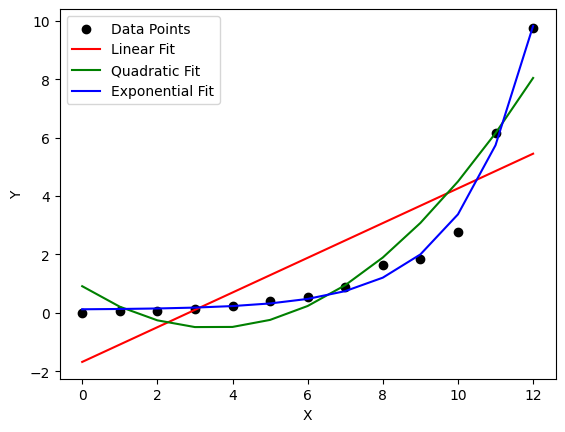

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the dataset as arrays of X and Y values
x_data = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
y_data = np.array([0.01079, 0.05478, 0.07859, 0.14194, 0.25000, 0.40342, 0.53241, 0.88065, 1.63551, 1.84502, 2.78552, 6.14152, 9.75936])

# Define the R-squared function
def r_squared(y, y_pred):
    residual = np.sum((y - y_pred) ** 2)
    total = np.sum((y - np.mean(y)) ** 2)
    r_sq = 1 - (residual / total)
    return r_sq

# Visualize the data and original points
plt.scatter(x_data, y_data, label='Data Points', color='black')
plt.xlabel('X')
plt.ylabel('Y')

# Fit a linear model to the data
def linear_func(x, a, b):
    return a * x + b

linear_params, _ = curve_fit(linear_func, x_data, y_data)
plt.plot(x_data, linear_func(x_data, *linear_params), 'r', label='Linear Fit')

# Fit a quadratic model to the data
def quadratic_func(x, a, b, c):
    return a * x**2 + b * x + c

quadratic_guesses = [1, 1, 1]  # Initial guesses for the quadratic fit
quadratic_params, _ = curve_fit(quadratic_func, x_data, y_data, p0=quadratic_guesses)
plt.plot(x_data, quadratic_func(x_data, *quadratic_params), 'g', label='Quadratic Fit')

# Fit an exponential model to the data
def exponential_func(x, a, b, c):
    return a * np.exp(b * x) + c

exponential_guesses = [2, 0.2, 2]  # Initial guesses for the exponential fit
exponential_params, _ = curve_fit(exponential_func, x_data, y_data, p0=exponential_guesses)
plt.plot(x_data, exponential_func(x_data, *exponential_params), 'b', label='Exponential Fit')

# Print the best fit
r_squared_values = {
    'Linear': r_squared(y_data, linear_func(x_data, *linear_params)),
    'Quadratic': r_squared(y_data, quadratic_func(x_data, *quadratic_params)),
    'Exponential': r_squared(y_data, exponential_func(x_data, *exponential_params))
}

best_fit = max(r_squared_values, key=r_squared_values.get)
print("Best Fit: ", best_fit)

plt.legend()
plt.show()



In [40]:
print("Quadratic guesses: ", quadratic_params)
print("Exponential guesses: ", exponential_params)

Quadratic guesses:  [ 0.11782931 -0.81993887  0.91428407]
Exponential guesses:  [0.01396663 0.54538719 0.11010673]


In [ ]:
# Generate random data from a normal distribution
mu = 2028  # Mean
sigma = 2  # Standard deviation
n = 10000
np.random.seed(42)  # Set the random seed for reproducibility
data = np.random.normal(mu, sigma, n)

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.set_style("whitegrid")

# Plot the histogram of the random data
sns.histplot(data, kde=True, ax=axes[0])
axes[0].set_title('Normal Distribution')

# Plot the CDF of the normal distribution
x = np.linspace(mu - 2 * sigma, mu + 2 * sigma, 1000)  # Range of x values
cdf = norm.cdf(x, mu, sigma)  # Calculate the CDF
sns.lineplot(x=x, y=cdf, ax=axes[1])  # Pass x-axis values as x argument
axes[1].set_title('Cumulative Distribution Function')

# Display the plot
plt.tight_layout()
plt.show()


This project we will analyze the increasing demand of EVs and who's leading it, figure out in which stage of adoption we are and try to estimate how long will it take for the all car transportation to become electric by finding the EV adoption curve.